/home/mikehenry/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


-----------
f4027fc7a645fbc9dbbb07d298ec55ec
R2 SAFO 0.9994847774386356
Ea 5.0
deltaT 0.0001
sec_bond_weight 1.0
% bonds per step 0.01
bond period 1


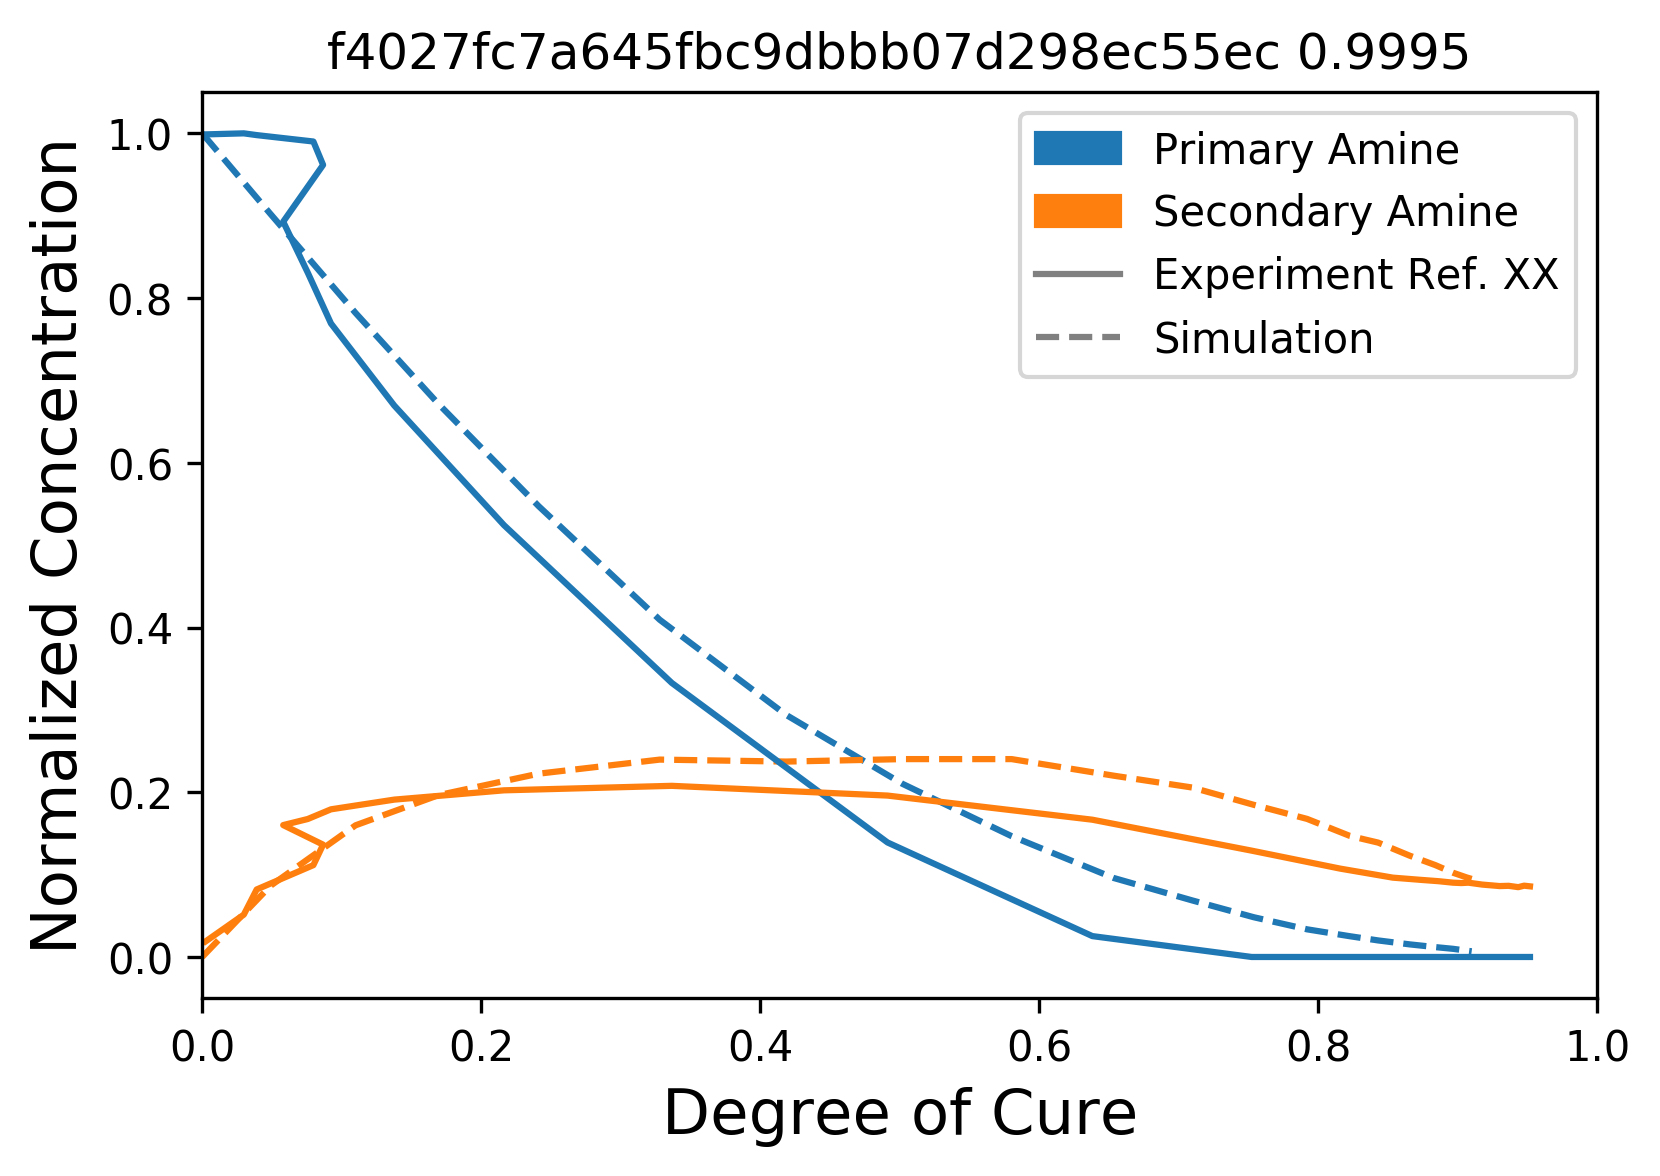

-----------
f665ff5e8e67f72caf87b7d23484e3a1
R2 SAFO 0.9993323726034957
Ea 5.0
deltaT 0.0001
sec_bond_weight 1.0
% bonds per step 1.0
bond period 100


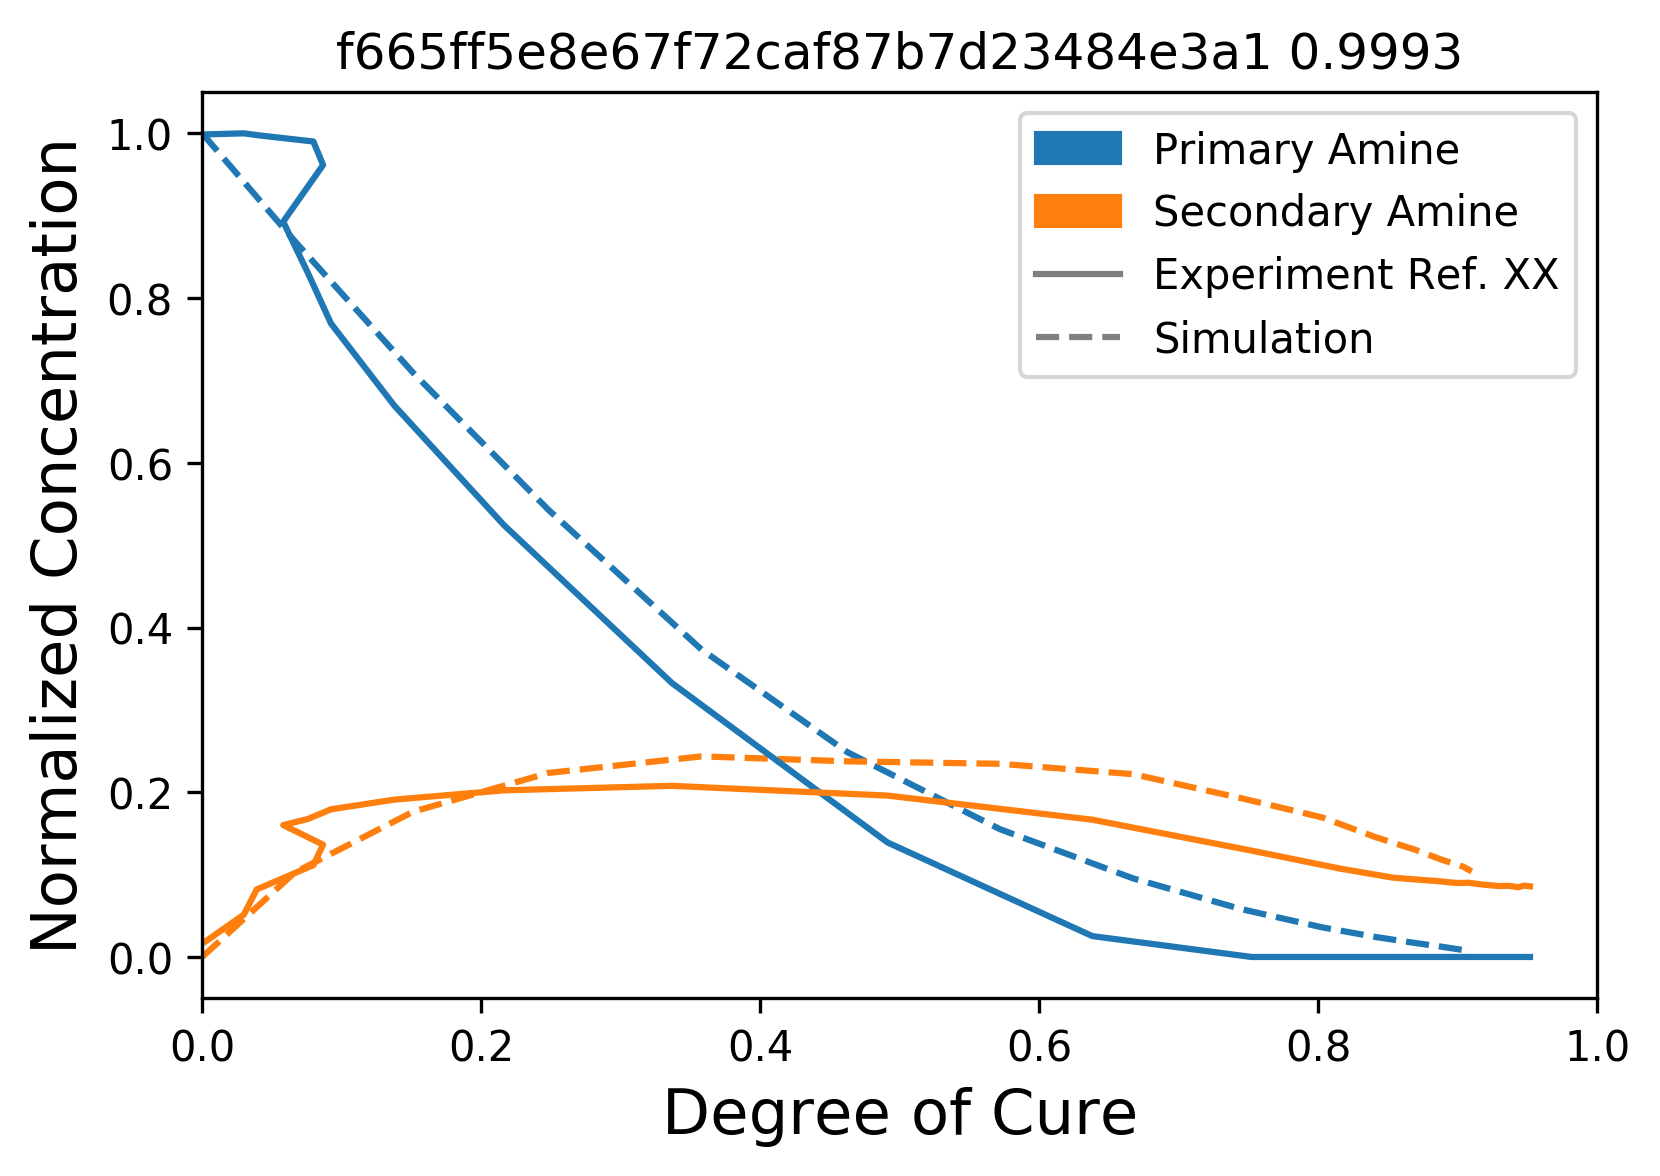

-----------
2b3cba7d5961ccc24e18d3978940303e
R2 SAFO 0.9994937829192911
Ea 5.0
deltaT 0.0001
sec_bond_weight 1.0
% bonds per step 0.1
bond period 100


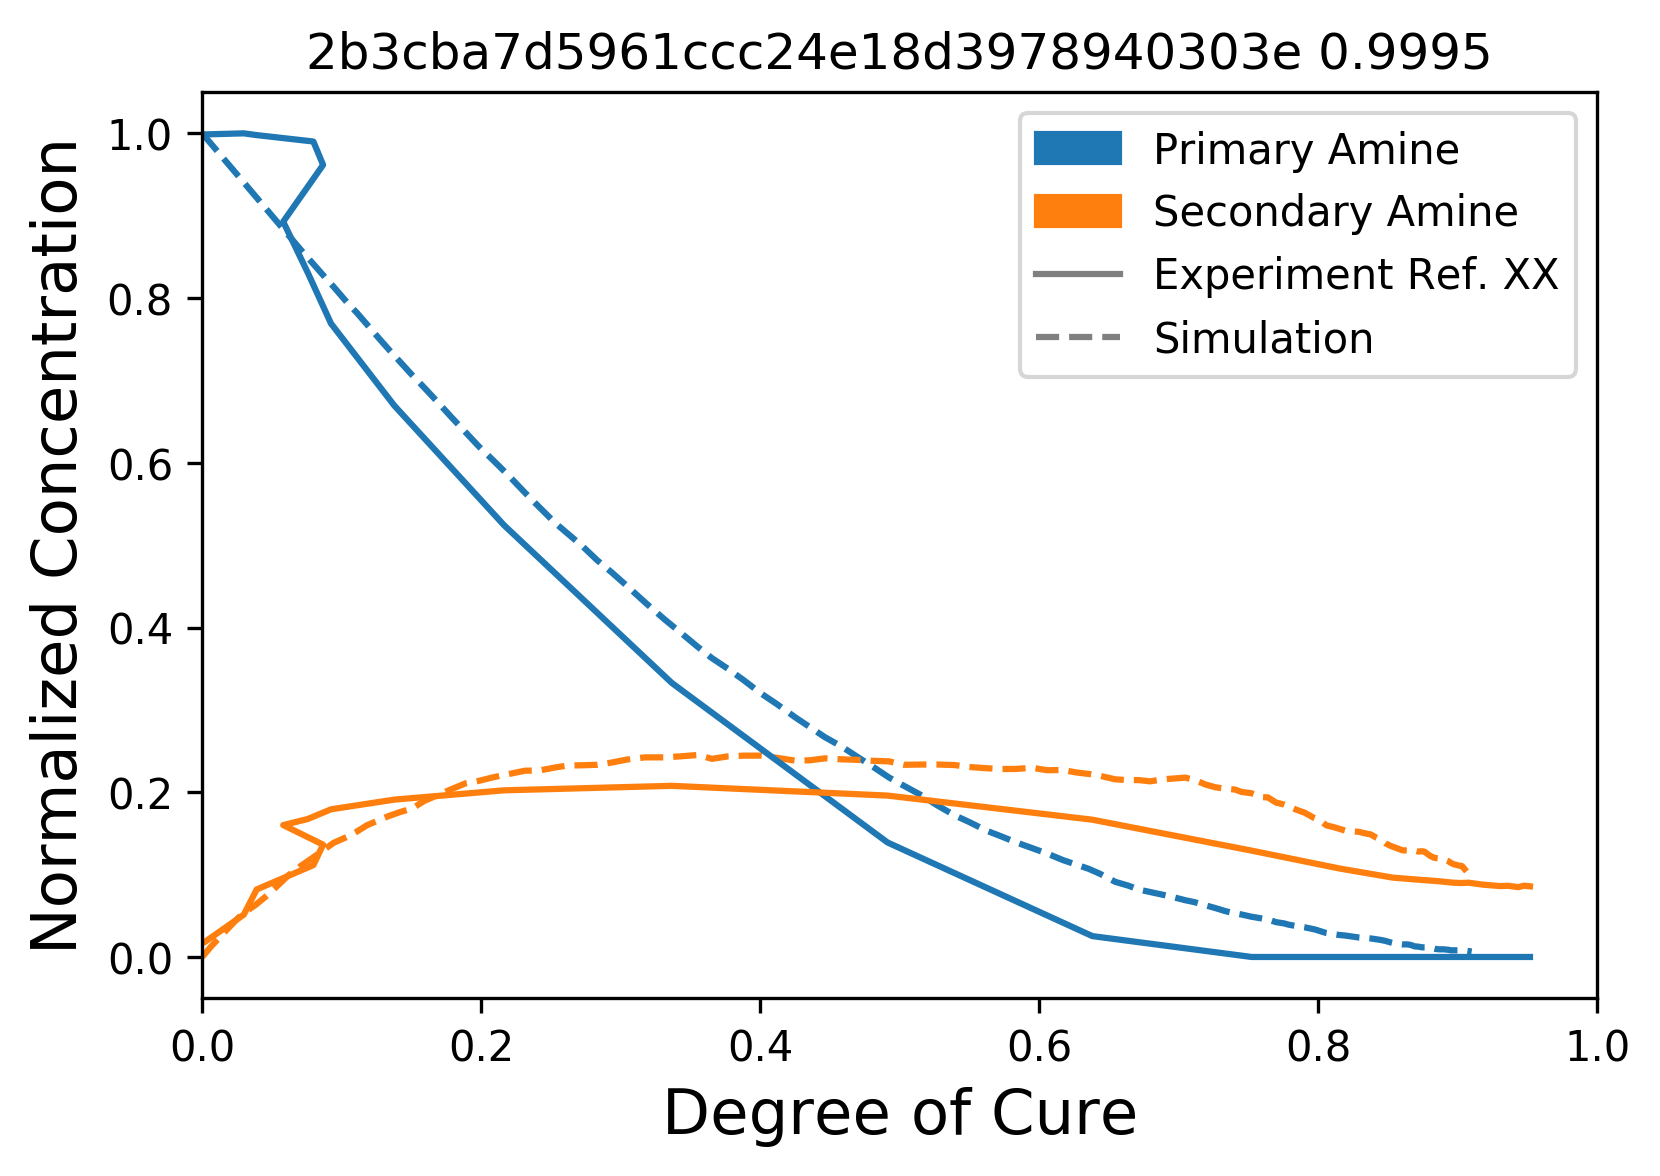

-----------
f7ddcd578917476c10a87a5cd62a569d
R2 SAFO 0.999587006350801
Ea 5.0
deltaT 0.0001
sec_bond_weight 1.0
% bonds per step 0.01
bond period 10


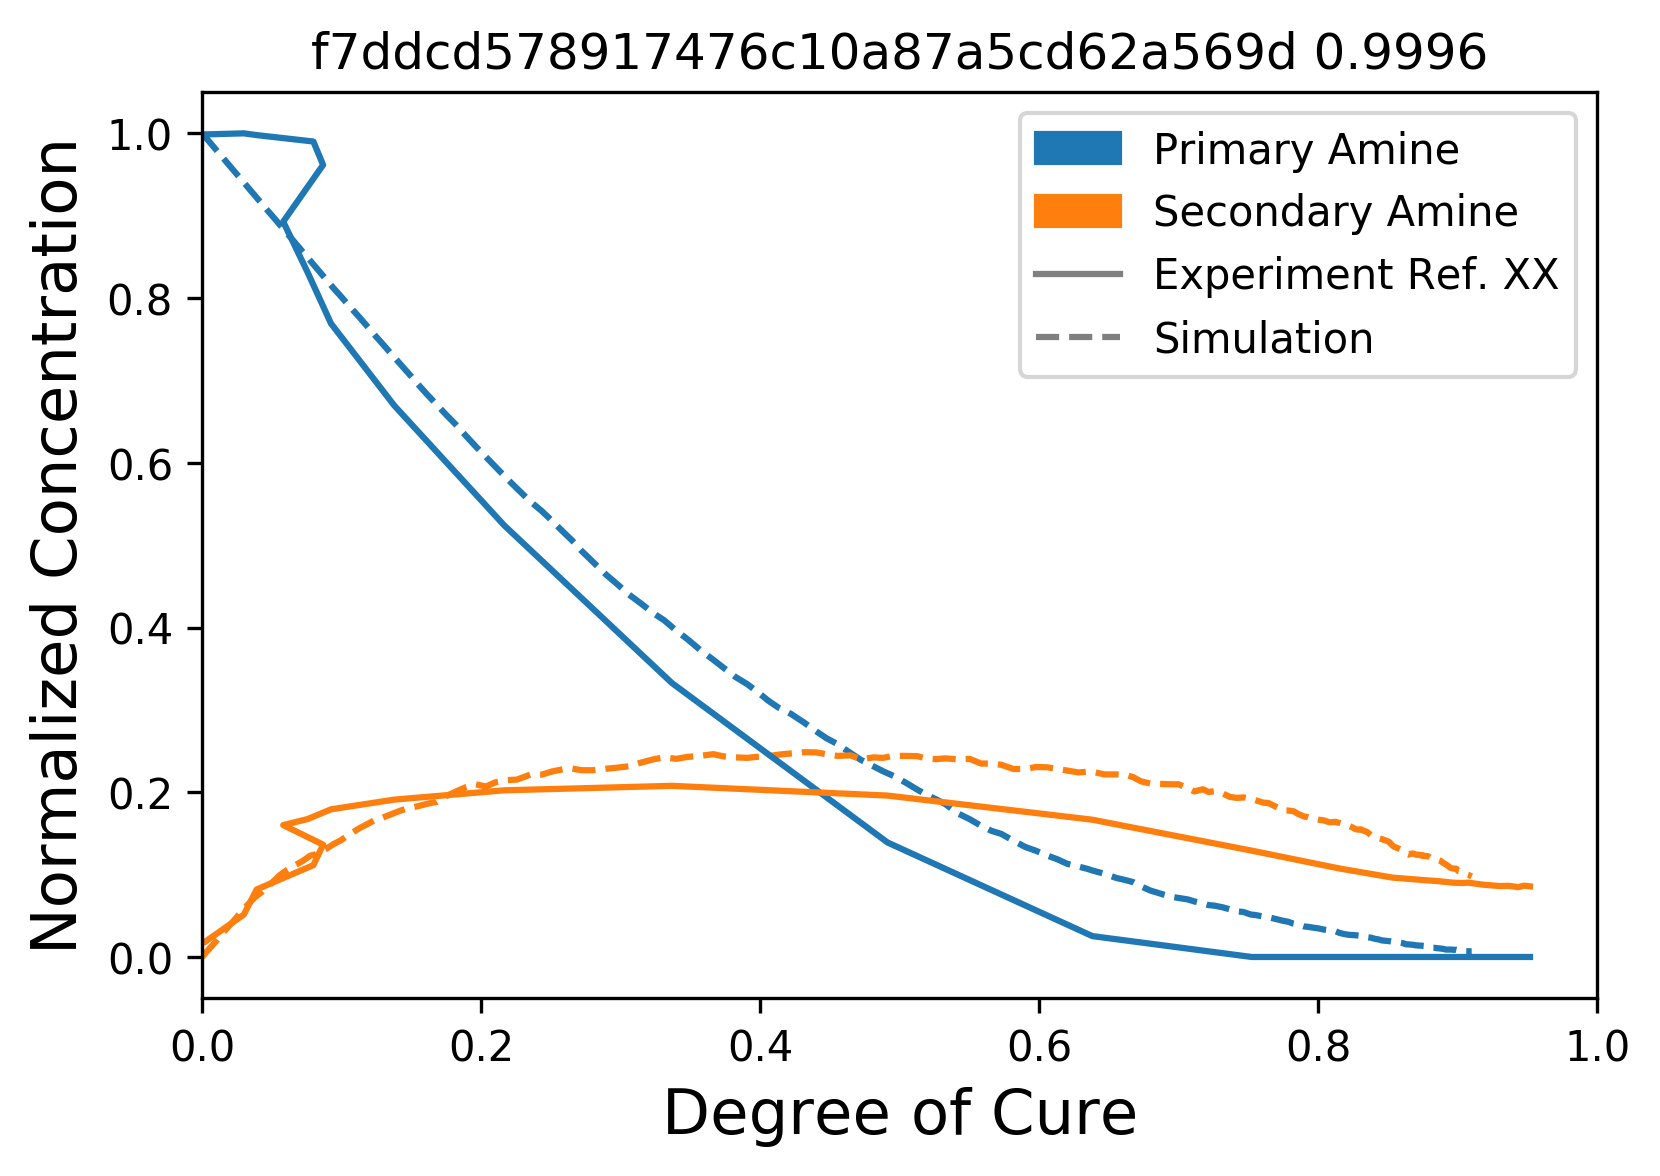

-----------
c0411b8524f9c3fb532f6b160d379dc0
R2 SAFO 0.9996002210121898
Ea 5.0
deltaT 0.0001
sec_bond_weight 1.0
% bonds per step 0.1
bond period 10


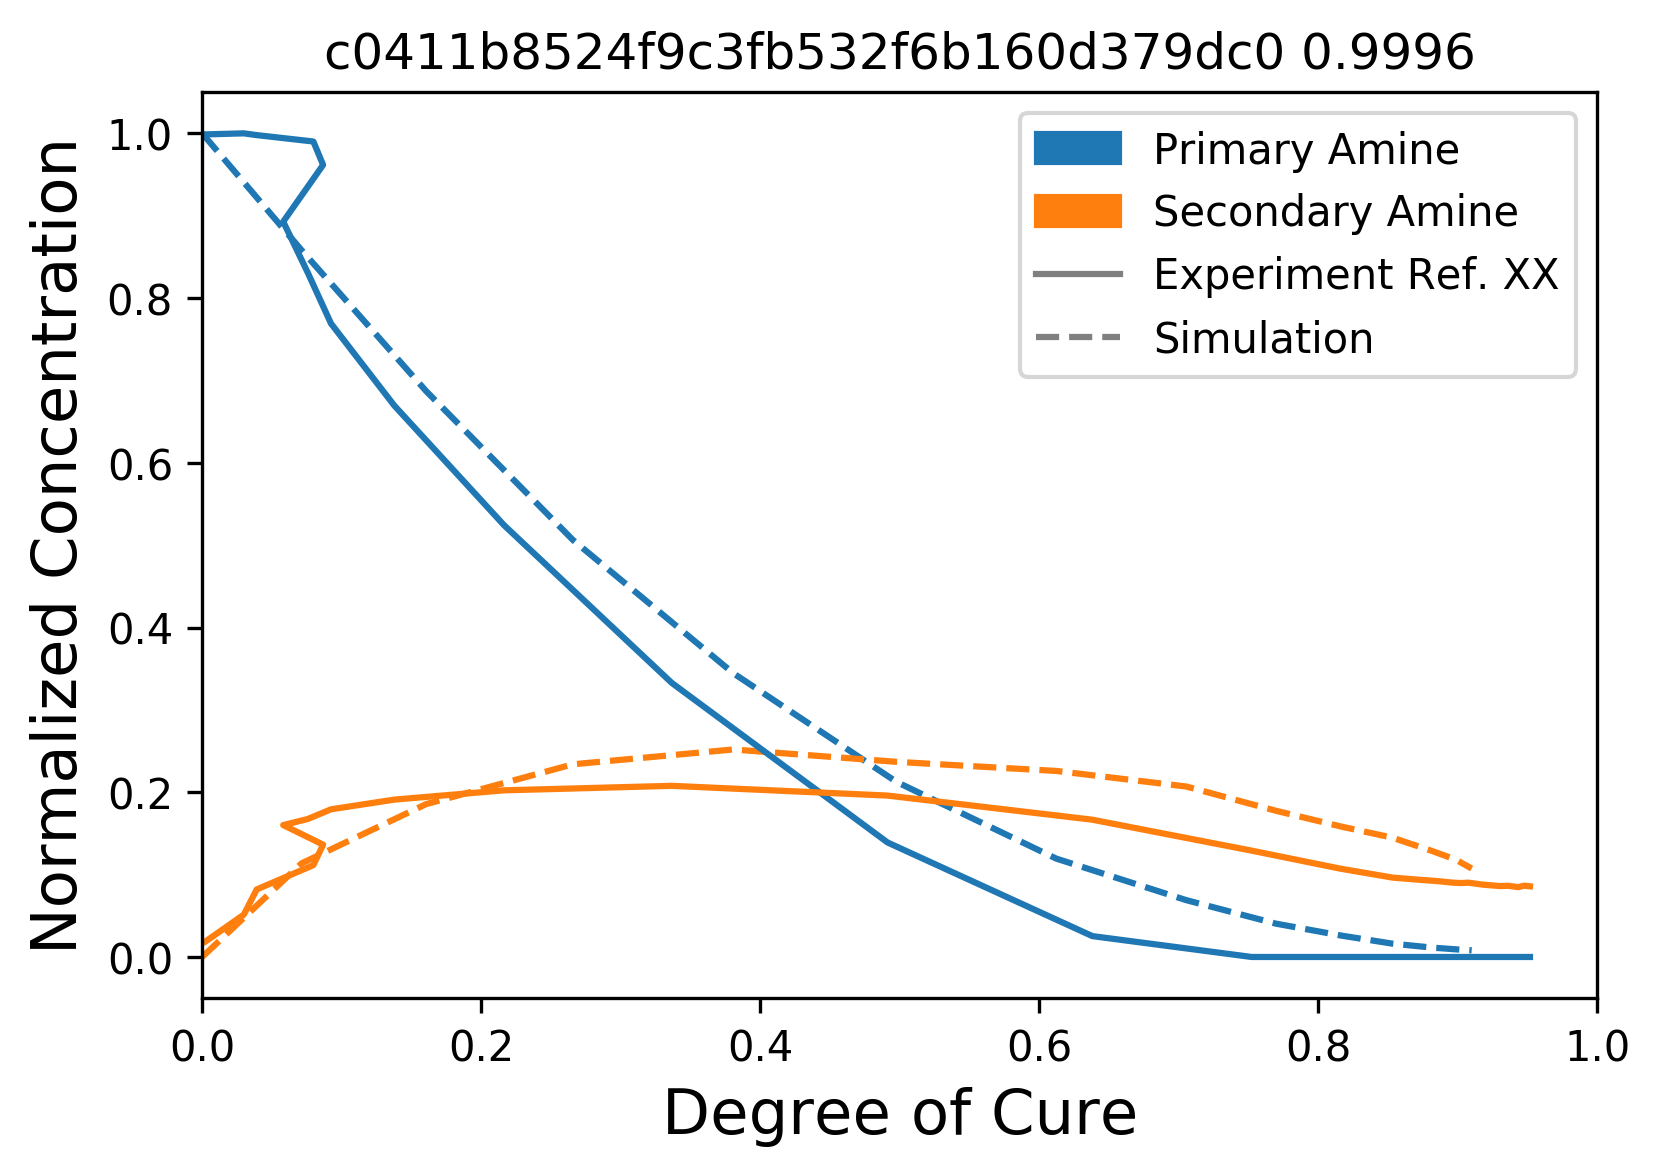

In [3]:
import pandas as pd
import signac
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import OrderedDict
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

path = "/home/mikehenry/epoxy-stuff/files_to_send_20200306"

project = signac.get_project(path)
jobs = project.find_jobs(filter={"bond": True}, doc_filter={"cure_percent":{"$gte":80}})

exp_data = np.load("../exp_data.npz")
doc, pa, sa, ta = exp_data["arr_0"], exp_data["arr_1"], exp_data["arr_2"], exp_data["arr_3"]

file_path = "../exp_data/Mike_Edits_Janisse_T44_NIR_Concentrations.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None, skiprows=[0,1], header=None)
first_sheet = sheets["Sheet6"]
first_sheet = first_sheet.convert_objects(convert_numeric=True).dropna()
scale_factor = first_sheet[4].max()

doc = np.asanyarray(first_sheet[1])/100
pa = np.asanyarray(first_sheet[4]/scale_factor)
sa = np.asanyarray(first_sheet[5]/scale_factor)

jobs = project.find_jobs(doc_filter={"cure_percent":{"$gte":80}})
R2s = []
for job in jobs:
    try:
        if job.doc.SAFO_model_R2 is not None:
            R2s.append((job.doc.SAFO_model_R2, job._id))
    except(AttributeError):
        continue
    
top_ten = [_[1] for _ in sorted(R2s)[-5:]]


for job in jobs:
    if job._id in top_ten:
        try:
            df = pd.read_csv(job.fn("_test_species.log"), delimiter="\t")
        except(FileNotFoundError):
            continue
        cure_fractions = np.asarray(df["#doc"])
        primaryA_cnts = np.asarray(df["primaryA"]) # 0
        secondaryA_cnts = np.asarray(df["secondaryA"]) # 1
        ternaryA_cnts = np.asarray(df["ternaryA"]) # 2 
        quarternaryA_cnts = np.asarray(df["quarternaryA"]) # 3
        fivernaryA_cnts = np.asarray(df["fivernaryA"]) # 4
        scale_factor = primaryA_cnts[0]*2
        primaryA_cnts=primaryA_cnts/scale_factor # 0
        secondaryA_cnts=secondaryA_cnts/scale_factor # 1
        ternaryA_cnts=ternaryA_cnts/scale_factor # 2
        quarternaryA_cnts=quarternaryA_cnts/scale_factor # 3
        fivernaryA_cnts=fivernaryA_cnts/scale_factor # 4

        P_high = primaryA_cnts*2+secondaryA_cnts+ternaryA_cnts
        P_low =  primaryA_cnts*2+secondaryA_cnts+ternaryA_cnts*0

        S_high = secondaryA_cnts + ternaryA_cnts*2 + quarternaryA_cnts
        S_low =  secondaryA_cnts + ternaryA_cnts*0 +quarternaryA_cnts

        T_high = ternaryA_cnts+quarternaryA_cnts+fivernaryA_cnts*2
        T_low = quarternaryA_cnts+fivernaryA_cnts*2

        plt.figure(dpi=300)

        #plt.plot(cure_fractions, P_high, color='#1f77b4', linestyle=":", label="high")
        plt.plot(cure_fractions, P_low, color='#1f77b4', linestyle="--", label="low")

        #plt.plot(cure_fractions, T_high, color="#2ca02c")
        #plt.plot(cure_fractions, T_low, color="#2ca02c")

        #plt.plot(cure_fractions, S_high, color="#ff7f0e", linestyle=":")
        plt.plot(cure_fractions, S_low, color="#ff7f0e", linestyle="--")




            #plt.fill_between(cure_fractions, S_low, S_high, label="Secondary",hatch="|||", alpha = 0.5, color="#ff7f0e")
            #plt.fill_between(cure_fractions, T_low, T_high, label="Tertiary",hatch="///", alpha = 0.5, color="#2ca02c")
            #plt.fill_between(cure_fractions, P_low, P_high, label="Primary",hatch="|", alpha = 0.8, color='#1f77b4')



        plt.plot(doc,pa, color='#1f77b4', linestyle='-', label="exp")
        plt.plot(doc,sa, color='#ff7f0e', linestyle='-')
        #plt.plot(doc,ta, color='#2ca02c', linestyle='--')

        primary = mpatches.Patch(color='#1f77b4', label='Primary Amine')
        seconday = mpatches.Patch(color='#ff7f0e', label='Secondary Amine')
        exp = mlines.Line2D([], [], color='grey', linestyle='-', label="Experiment Ref. XX")
        #high = mlines.Line2D([], [], color='grey', linestyle=':', label="Simulation High Count")
        low = mlines.Line2D([], [], color='grey', linestyle='--', label="Simulation")



        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), prop={'size': 15})
        plt.legend(handles=[primary,seconday,exp, low])


        #plt.title("activation_energy: {} \n bond_period: {} deltaT: {} percent_bonds_per_step: {} \n sec_bond_weight: {}".format(job.sp.activation_energy,
        #                                             job.sp.bond_period,
        #                                             job.sp.deltaT,
        #                                            job.sp.percent_bonds_per_step,
        #                                            job.sp.sec_bond_weight),
        #                                            )

        print("-----------")
        print(job._id)
        print("R2 SAFO", job.doc.SAFO_model_R2)
        print("Ea", job.sp.activation_energy)
        print("deltaT", job.sp.deltaT)
        print("sec_bond_weight", job.sp.sec_bond_weight)
        print("% bonds per step" ,job.sp.percent_bonds_per_step)
        print("bond period", job.sp.bond_period)
        plt.title(str(job._id)+ " "+ str(round(job.doc.SAFO_model_R2,4)))
        plt.xlabel("Degree of Cure", size=15)
        plt.ylabel("Normalized Concentration", size=15)
        plt.xlim(0,1)
        plt.show()